# Automatic Feature Engineering with Featuretools
by Matthew Emery

In [134]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import featuretools as ft
from random import sample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, confusion_matrix, matthews_corrcoef
import warnings
from itertools import chain
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from IPython.core.debugger import set_trace
from tpot import TPOTClassifier, config
%matplotlib inline

warnings.filterwarnings('ignore')

In [106]:
train_df = pd.read_csv("data/train.csv")
train_target = train_df["Survived"]
train_features = train_df.drop(columns="Survived")
train_features['Pclass'] = train_features['Pclass'].astype('category')
train_features.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
474,475,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
584,585,3,"Paulner, Mr. Uscher",male,NaN,0,0,3411,8.7125,NaN,C
662,663,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [101]:
basic_features = pd.get_dummies(train_features.drop(columns=["Name", "PassengerId", "Ticket", "Cabin"]))

dummy_model = DummyClassifier(random_state=0)
dummy_cv = cross_val_score(dummy_model, basic_features, train_target, cv=5, scoring= make_scorer(matthews_corrcoef))
dummy_cv.mean(), dummy_cv.std()

(-0.0035352655356036765, 0.047852075615070044)

In [128]:

basic_model = make_pipeline(Imputer(strategy="median"), 
                            StandardScaler(),
                            LogisticRegressionCV(random_state=0, cv = 5))
basic_cv = cross_val_score(basic_model, 
                           basic_features, 
                           train_target, 
                           cv=5)
basic_cv.mean(), basic_cv.std()

(0.7979954159658158, 0.022894811329189232)

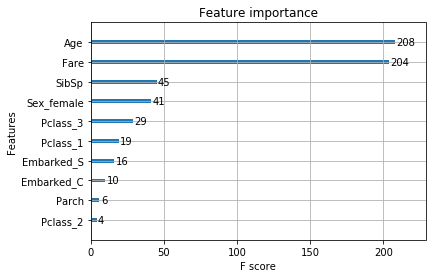

In [94]:
basic_model.fit(basic_features, train_target)
plot_importance(basic_model, max_num_features=20)

In [107]:
#How about some feature engineering?
ft_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=ft_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked

In [25]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,embarkeds.MEAN(titanic.Parch),embarkeds.MEAN(titanic.Fare),embarkeds.COUNT(titanic),embarkeds.NUM_UNIQUE(titanic.Pclass),embarkeds.NUM_UNIQUE(titanic.Sex),embarkeds.MODE(titanic.Pclass) = 3.0,embarkeds.MODE(titanic.Pclass) = 1.0,embarkeds.MODE(titanic.Pclass) = unknown,embarkeds.MODE(titanic.Sex) = male,embarkeds.MODE(titanic.Sex) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
506,18.0,1,0,108.9000,0,1,0,0,1,0,...,0.363095,59.954144,168.0,3.0,2.0,0,1,0,1,0
871,26.0,0,0,7.8958,1,0,0,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
792,16.0,0,0,26.0000,0,0,1,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
481,9.0,5,2,46.9000,1,0,0,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
182,NaN,0,0,15.0500,0,0,1,0,1,0,...,0.363095,59.954144,168.0,3.0,2.0,0,1,0,1,0


In [68]:
class FeaturetoolsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.features = None
        
    def fit(self, X, y=None):
        entity_set = self._create_entity(X)
        entity_set, features = ft.dfs(entityset=entity_set, target_entity="id")
        _, self.features = ft.encode_features(entity_set, features)
        return self

    def transform(self, X, y=None):
        if not self.features:
            raise ValueError("Fit the FeaturetoolsTransformer first")
        else:
            entity_set = self._create_entity(X)
            X = ft.calculate_feature_matrix(self.features, entityset=entity_set)
            return X
        
    def _create_entity(self, X):
        X = X.reset_index()
        variable_types = {variable: ft.variable_types.Categorical for variable in self.categorical_features}
        es = ft.EntitySet(id="id")
        es.entity_from_dataframe(entity_id="id",
                                 dataframe=X,
                                 index = "index",
                                 variable_types=variable_types)
        for variable in self.categorical_features:
            es.normalize_entity(base_entity_id="id",
                            new_entity_id=variable,
                            index=variable)
        return es

In [73]:
ft_transformer = FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"])
ft_transformer.fit_transform(ft_features).sample(5)

,PassengerId,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,...,Embarked.MEAN(id.Parch),Embarked.MEAN(id.Fare),Embarked.COUNT(id),Embarked.NUM_UNIQUE(id.Pclass),Embarked.NUM_UNIQUE(id.Sex),Embarked.MODE(id.Pclass) = 3.0,Embarked.MODE(id.Pclass) = 1.0,Embarked.MODE(id.Pclass) = unknown,Embarked.MODE(id.Sex) = male,Embarked.MODE(id.Sex) = unknown
index,,,,,,,,,,,,,,,,,,,,,
751,752,6.0,0,1,12.4750,True,False,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
332,333,38.0,0,1,153.4625,False,True,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
498,499,25.0,1,2,151.5500,False,True,False,False,False,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
212,213,22.0,0,0,7.2500,True,False,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
592,593,47.0,0,0,7.2500,True,False,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False


In [74]:
sample(ft_transformer.features, 5)

[<Feature: Pclass = unknown>,
 <Feature: Pclass.SUM(id.Age)>,
 <Feature: Sex.STD(id.SibSp)>,
 <Feature: Pclass.MIN(id.PassengerId)>,
 <Feature: Embarked.MEAN(id.Parch)>]

In [129]:
ft_pipeline = make_pipeline(
    FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"]),
    Imputer(strategy="median"),
    
                            StandardScaler(),
    LogisticRegressionCV(random_state=0, cv = 5))

In [130]:
ft_cv = cross_val_score(ft_pipeline, ft_features, train_target, cv=5)
ft_cv.mean(), ft_cv.std()

(0.40405981019133713, 0.11954462450860799)

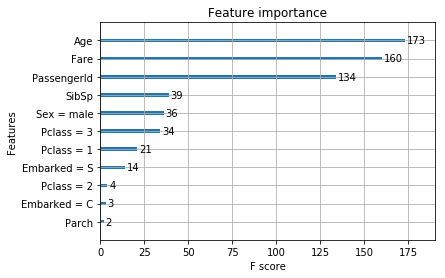

In [85]:
ft_transformer = FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"])
transformed_ft_features = ft_transformer.fit_transform(ft_features)


plot_importance(ft_pipeline.named_steps['xgbclassifier'])

In [84]:
ft_pipeline.named_steps['featuretoolstransformer'].features

[<Feature: PassengerId>,
 <Feature: Age>,
 <Feature: SibSp>,
 <Feature: Parch>,
 <Feature: Fare>,
 <Feature: Pclass = 3>,
 <Feature: Pclass = 1>,
 <Feature: Pclass = 2>,
 <Feature: Pclass = unknown>,
 <Feature: Sex = male>,
 <Feature: Sex = female>,
 <Feature: Sex = unknown>,
 <Feature: Embarked = S>,
 <Feature: Embarked = C>,
 <Feature: Embarked = Q>,
 <Feature: Embarked = unknown>,
 <Feature: Pclass.SUM(id.PassengerId)>,
 <Feature: Pclass.SUM(id.Age)>,
 <Feature: Pclass.SUM(id.SibSp)>,
 <Feature: Pclass.SUM(id.Parch)>,
 <Feature: Pclass.SUM(id.Fare)>,
 <Feature: Pclass.STD(id.PassengerId)>,
 <Feature: Pclass.STD(id.Age)>,
 <Feature: Pclass.STD(id.SibSp)>,
 <Feature: Pclass.STD(id.Parch)>,
 <Feature: Pclass.STD(id.Fare)>,
 <Feature: Pclass.MAX(id.PassengerId)>,
 <Feature: Pclass.MAX(id.Age)>,
 <Feature: Pclass.MAX(id.SibSp)>,
 <Feature: Pclass.MAX(id.Parch)>,
 <Feature: Pclass.MAX(id.Fare)>,
 <Feature: Pclass.SKEW(id.PassengerId)>,
 <Feature: Pclass.SKEW(id.Age)>,
 <Feature: Pclass.SK

In [122]:
train_features['CabinClass'] = train_features["Cabin"].str.get(0)
train_features['LastName'] = train_features['Name'].str.split(", ").apply(lambda x: x[0])
train_features['Honorific'] = train_features['Name'].str.extract(" ([a-zA-z]+)")
train_features['TicketPrefix'] = train_features['Ticket'].str.extract("(.+) ")
train_features = train_features.drop(columns=["Name", "Cabin", "Ticket"])

KeyError: 'Cabin'

In [145]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 270 features
Elapsed: 00:05 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,ticketprefixes.MODE(titanic.LastName) = Corn,ticketprefixes.MODE(titanic.LastName) = Hakkarainen,ticketprefixes.MODE(titanic.LastName) = unknown,ticketprefixes.MODE(titanic.Honorific) = Mr,ticketprefixes.MODE(titanic.Honorific) = Miss,ticketprefixes.MODE(titanic.Honorific) = Master,ticketprefixes.MODE(titanic.Honorific) = Capt,ticketprefixes.MODE(titanic.Honorific) = Rev,ticketprefixes.MODE(titanic.Honorific) = Mrs,ticketprefixes.MODE(titanic.Honorific) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
744,24.0,1,0,16.1000,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
359,NaN,0,0,7.8792,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
273,41.0,0,1,19.5000,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
487,35.0,1,0,90.0000,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
143,24.0,1,0,15.8500,1,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0


In [125]:
fte_pipeline = make_pipeline(FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"]),
                             Imputer(strategy="median"),
    LogisticRegressionCV(random_state=0, cv = 5))

In [126]:
expanded_ft_cv = cross_val_score(fte_pipeline, 
                                 train_features, 
                                 train_target, 
                                 cv=5)
expanded_ft_cv.mean(), expanded_ft_cv.std()

(0.6166122831263496, 0.11424474109484013)

In [127]:
picky_pipeline = make_pipeline(
    FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"]),
    Imputer(strategy="median"),
    SelectFromModel(ExtraTreesClassifier(random_state=20, n_estimators=500), 'median'),
    LogisticRegressionCV(random_state=0, cv = 5)
)

selected_ft_cv = cross_val_score(picky_pipeline, 
                                 train_features, 
                                 train_target, 
                                 cv=5, 
                                 scoring= make_scorer(matthews_corrcoef))
selected_ft_cv.mean(), selected_ft_cv.std()

(0.20289944467563242, 0.24031027023796514)

In [14]:
basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv

(array([0.78888889, 0.82222222, 0.7752809 , 0.84269663, 0.88764045,
        0.80898876, 0.83146067, 0.76404494, 0.82022472, 0.85227273]),
 array([0.78888889, 0.85555556, 0.7752809 , 0.83146067, 0.8988764 ,
        0.83146067, 0.83146067, 0.7752809 , 0.82022472, 0.84090909]),
 array([0.78888889, 0.81111111, 0.79775281, 0.86516854, 0.86516854,
        0.80898876, 0.84269663, 0.82022472, 0.82022472, 0.86363636]),
 array([0.76666667, 0.82222222, 0.79775281, 0.85393258, 0.86516854,
        0.82022472, 0.86516854, 0.80898876, 0.83146067, 0.84090909]))

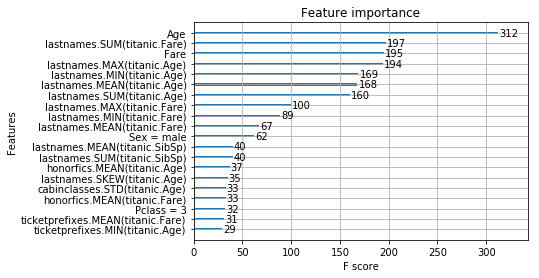

In [15]:
basic_model.fit(feature_matrix, train_target)
plot_importance(basic_model, max_num_features=20)

In [16]:
df = pd.DataFrame(
    {"Model": list(chain.from_iterable([[x] * 10 for x in ("Basic Features", 
                                                           "Naive Featuretools",
                                                           "Smarter Featuretools",
                                                           "Selected Featuretools")])),
        "CV Fold Accuracy": np.concatenate([basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv])} )

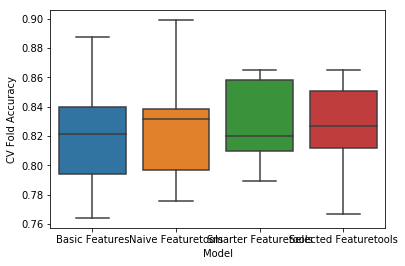

In [17]:
sns.boxplot("Model", "CV Fold Accuracy", data = df)

In [138]:
## Talk about TPOT
ft_config_dict = {'FeaturetoolsTransformer': {'categorical_features' : 
                  [["Pclass", "Sex", "Embarked", "CabinClass", 
                     "LastName", "Honorific", "TicketPrefix"]]}
}
custom_config_dict = {**ft_config_dict, **config.classifier.classifier_config_dict}

In [148]:
tpot = TPOTClassifier(periodic_checkpoint_folder="results/checkpoints", 
                      cv = 5, 
                      verbose=2, 
                      n_jobs=-1,
                      generations=10)

TypeError: __init__() got an unexpected keyword argument 'verbose'

In [147]:
tpot.fit(feature_matrix, target=train_target)

TypeError: fit() got an unexpected keyword argument 'verbose'

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinClass,LastName,Honorific,TicketPrefix
0,1,3,male,22.0,1,0,7.2500,S,NaN,Braund,Mr,A/5
1,2,1,female,38.0,1,0,71.2833,C,C,Cumings,Mrs,PC
2,3,3,female,26.0,0,0,7.9250,S,NaN,Heikkinen,Miss,STON/O2.
3,4,1,female,35.0,1,0,53.1000,S,C,Futrelle,Mrs,NaN
4,5,3,male,35.0,0,0,8.0500,S,NaN,Allen,Mr,NaN
5,6,3,male,NaN,0,0,8.4583,Q,NaN,Moran,Mr,NaN
6,7,1,male,54.0,0,0,51.8625,S,E,McCarthy,Mr,NaN
7,8,3,male,2.0,3,1,21.0750,S,NaN,Palsson,Master,NaN
8,9,3,female,27.0,0,2,11.1333,S,NaN,Johnson,Mrs,NaN
9,10,2,female,14.0,1,0,30.0708,C,NaN,Nasser,Mrs,NaN
